In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nvidia_model import load_multi_dataset,filter_dataset
import cv2

In [30]:
train_dataset_folder = ["official_baseline/","trip1_off_recover/","track2_1/","track2_2/"]
train_dataset_folder = ["official_baseline/"]

In [31]:
log_df=load_multi_dataset(train_dataset_folder)

In [32]:
log_df.head()

,center,left,right,steering,throttle,brake,speed
0,./data/official_baseline/IMG/center_2016_12_01...,./data/official_baseline/IMG/left_2016_12_01_1...,./data/official_baseline/IMG/right_2016_12_01_...,0.0,0.0,0.0,22.148290
1,./data/official_baseline/IMG/center_2016_12_01...,./data/official_baseline/IMG/left_2016_12_01_1...,./data/official_baseline/IMG/right_2016_12_01_...,0.0,0.0,0.0,21.879630
2,./data/official_baseline/IMG/center_2016_12_01...,./data/official_baseline/IMG/left_2016_12_01_1...,./data/official_baseline/IMG/right_2016_12_01_...,0.0,0.0,0.0,1.453011
3,./data/official_baseline/IMG/center_2016_12_01...,./data/official_baseline/IMG/left_2016_12_01_1...,./data/official_baseline/IMG/right_2016_12_01_...,0.0,0.0,0.0,1.438419
4,./data/official_baseline/IMG/center_2016_12_01...,./data/official_baseline/IMG/left_2016_12_01_1...,./data/official_baseline/IMG/right_2016_12_01_...,0.0,0.0,0.0,1.418236


In [33]:
log_df.shape

(8036, 7)

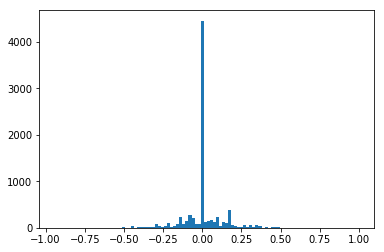

In [34]:
plt.hist(log_df['steering'],bins=100)
plt.show()

## Histograms after filtering

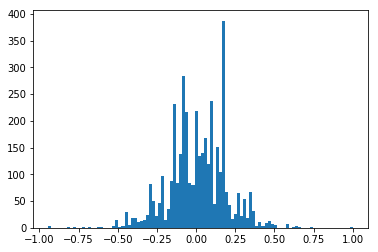

In [35]:
filtered_log_df=filter_dataset(log_df)
plt.hist(filtered_log_df["steering"],bins=100)
plt.show()

In [36]:
## Load a model
from keras.models import load_model

trained_model=load_model("model_v8.h5")

In [37]:
from sklearn.utils import shuffle
def generator(samples, batch_size=32, shuffle_samples=True,cam_index=0):
    num_samples = len(samples)

    while True:  # Loop forever so the generator never terminates
        if shuffle_samples:
            print("reshuffled")
            samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):

            batch_samples = samples.iloc[offset:min(offset + batch_size, num_samples), cam_index]

            images = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(batch_sample)
                images.append(center_image)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = samples.iloc[offset:min(offset + batch_size, num_samples), 3]

            yield X_train, y_train

Get predicted label of center camera

In [38]:
batch_size=128
pred_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size)
pred=trained_model.predict_generator(pred_gen,val_samples=filtered_log_df.shape[0])

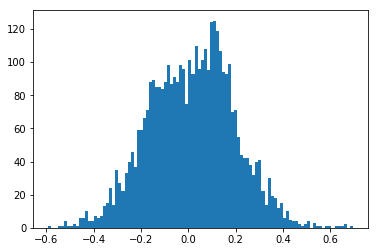

In [39]:
plt.hist(pred,bins=100)
plt.show()

Get "true" labels

In [40]:
true_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size)
y_train=[]
for offset in range(0,filtered_log_df.shape[0],batch_size):
    y_train=np.concatenate([y_train,next(true_gen)[1].values])

In [41]:
assert pred.shape[0]==y_train.shape[0]

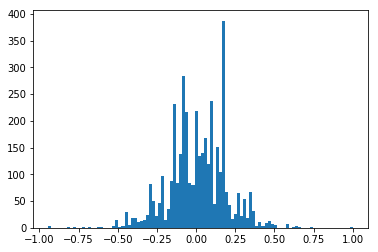

In [42]:
plt.hist(y_train,bins=100)
plt.show()

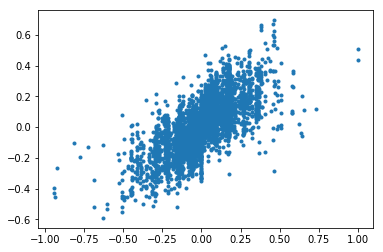

In [43]:
plt.plot(y_train,pred,'.')

In [44]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err=linregress(y_train.ravel(),pred.ravel())

0.697609849697
0.00854738273409


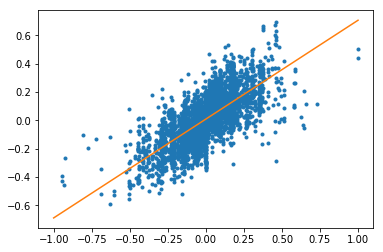

In [45]:
x=np.linspace(-1,1,num=20)
plt.plot(y_train,pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)

In [46]:
pred_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size,cam_index=1)
left_pred=trained_model.predict_generator(pred_gen,val_samples=filtered_log_df.shape[0])

0.68326177119
0.181276389256


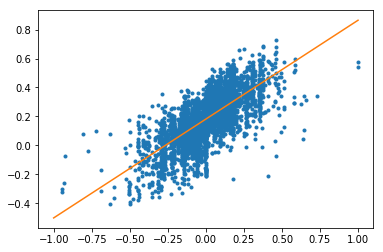

In [47]:
slope, intercept, r_value, p_value, std_err=linregress(y_train.ravel(),left_pred.ravel())
x=np.linspace(-1,1,num=20)
plt.plot(y_train,left_pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)

In [48]:
pred_gen=generator(filtered_log_df,shuffle_samples=False,batch_size=batch_size,cam_index=2)
right_pred=trained_model.predict_generator(pred_gen,val_samples=filtered_log_df.shape[0])

0.677257444522
-0.151886505147


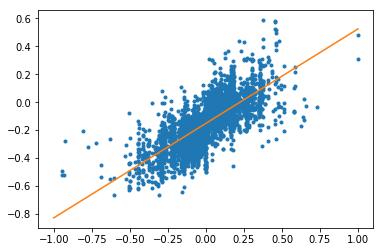

In [49]:
slope, intercept, r_value, p_value, std_err=linregress(y_train.ravel(),right_pred.ravel())
x=np.linspace(-1,1,num=20)
plt.plot(y_train,right_pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)

0.910063619633
-0.159223382448


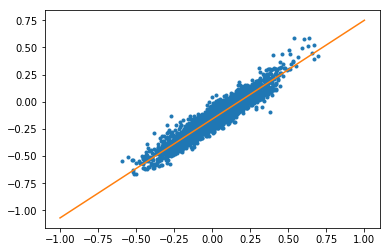

In [50]:
slope, intercept, r_value, p_value, std_err=linregress(pred.ravel(),right_pred.ravel())
x=np.linspace(-1,1,num=20)
plt.plot(pred,right_pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)

0.93169088445
0.173659988301


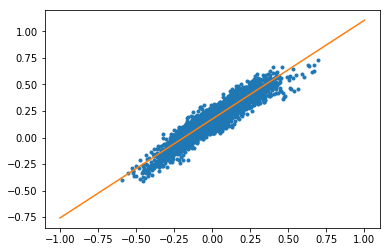

In [51]:
slope, intercept, r_value, p_value, std_err=linregress(pred.ravel(),left_pred.ravel())
x=np.linspace(-1,1,num=20)
plt.plot(pred,left_pred,'.')
plt.plot(x,x*slope+intercept)
print(slope)
print(intercept)